In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap

from mechir.data import CatDataCollator, DotDataCollator, MechDataset
import torch

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def process_frame(frame):

    output = {
        'qid': [],
        'query': [],
        'docno': [],
        'text': [],
        'perturbed': [],
    }

    for row in frame.itertuples():
        output['qid'].append(row.qid)
        output['query'].append(row.query)
        output['docno'].append(row.docno)
        output['text'].append(row.text)
        output['perturbed'].append(row.perturbed_text)
    
    return pd.DataFrame(output)

Matplotlib created a temporary cache directory at /home/scratch_local/esx208-1107593/tmp/matplotlib-gc0w6qcr because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eickhoff/esx208/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 200
sim_fn = 'dot'

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_block_all.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('block_all', 'block_all_original_scores'))
perturbed_scores = np.load(data_path.replace('block_all', 'block_all_perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda text: text.rsplit(' ', 1)[-1])

/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
score_difference = perturbed_scores - original_scores
patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis, np.newaxis])))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis, np.newaxis]))))

In [4]:
processed_frame = process_frame(all_data_pd)
dataset = MechDataset(processed_frame, pre_perturbed=True)
collator = DotDataCollator(tokenizer, pre_perturbed=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collator, shuffle=False)

In [5]:
# test_frame = [
#     {
#         'qid': 0,
#         'query': 'what is your name',
#         'docno': 0,
#         'text': 'my name is sebastian',
#         'perturbed': 'my name is sebastian name',
#         'injected_term': 'name'
#     },
#     {
#         'qid': 1,
#         'query': 'what is the weather in tubingen',
#         'docno': 1,
#         'text': 'the weather ulm is 20 degrees celcius',
#         'perturbed': 'the weather ulm is 20 degrees celcius tubingen',
#         'injected_term': 'tubingen'
#     }
# ]
# test_frame = pd.DataFrame(test_frame)
# test_dataset = MechDataset(test_frame, pre_perturbed=True)
# test_collator = DotDataCollator(tokenizer, pre_perturbed=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=test_collator, shuffle=False)

# for i, batch in enumerate(tqdm(test_dataloader)):
#     injected_term = test_frame.iloc[i]['injected_term']
#     injected_term_tokens = tokenizer(injected_term, add_special_tokens=False)['input_ids']
#     query = test_frame.iloc[i]['query']
#     query_token_list = [tokenizer(term, add_special_tokens=False)['input_ids'] for term in query.split()]
    
#     curr_attn_mask = batch['documents']['attention_mask'][0]
#     curr_doc_toks = batch['documents']['input_ids'][0][curr_attn_mask == 1]
#     curr_patching_results = patching_results[i, :, :, curr_attn_mask == 1].transpose(1, 2, 0)
    
#     og_doc_start_idx = 1
#     og_doc_end_idx = len(curr_doc_toks) - len(injected_term_tokens) - 2
    
#     inj_tok_idxs = []
#     non_inj_tok_idxs = []
#     for query_tokens in query_token_list:
#         print(query_tokens)
#         for i in range(og_doc_start_idx, og_doc_end_idx + 1 - len(query_tokens)):
#             window = curr_doc_toks[i:i + len(query_tokens)].tolist()
#             if window == query_tokens:
#                 window_range = range(i, i + len(query_tokens))
#                 if window == injected_term_tokens:
#                     inj_tok_idxs.extend(window_range)
#                 else:
#                     non_inj_tok_idxs.extend(window_range)
    
#     all_doc_idxs = list(range(og_doc_start_idx, og_doc_end_idx + 1))
#     non_q_term_idxs = list(set(all_doc_idxs) - set(inj_tok_idxs) - set(non_inj_tok_idxs))
        
#     print(query)
#     print(tokenizer.decode(curr_doc_toks[og_doc_end_idx+1:-1]))
#     print(inj_tok_idxs)
#     print(tokenizer.decode(curr_doc_toks[inj_tok_idxs]))
#     print(non_inj_tok_idxs)
#     print(tokenizer.decode(curr_doc_toks[non_inj_tok_idxs]))
#     print(tokenizer.decode(curr_doc_toks[og_doc_start_idx:og_doc_end_idx + 1]))
#     print('#'*100)

In [6]:
def segment_patching_results(dataloader, all_data_pd, patching_results, include_stopwords=True):
    patching_results_grouped = []
    for idx, batch in enumerate(tqdm(dataloader)):
        injected_term = all_data_pd.iloc[idx]['injected_term']
        injected_term_tokens = tokenizer(injected_term, add_special_tokens=False)['input_ids']
        query = all_data_pd.iloc[idx]['query']
        query_token_list = [tokenizer(term, add_special_tokens=False)['input_ids'] for term in query.split() if include_stopwords or term not in stopwords]
        
        curr_attn_mask = batch['perturbed_documents']['attention_mask'][0]
        curr_doc_toks = batch['perturbed_documents']['input_ids'][0][curr_attn_mask == 1]
        curr_patching_results = patching_results[idx, :, :, curr_attn_mask == 1].transpose(1, 2, 0)
        
        og_doc_start_idx = 1
        og_doc_end_idx = len(curr_doc_toks) - len(injected_term_tokens) - 2
        cls_tok_results = curr_patching_results[:, :, 0][:, :, np.newaxis]
        sep_tok_results = curr_patching_results[:, :, -1][:, :, np.newaxis]
        inj_tok_results = np.mean(curr_patching_results[:,:,og_doc_end_idx+1:-1], axis=-1)[:,:,np.newaxis]
        
        inj_tok_idxs = []
        non_inj_tok_idxs = []
        for query_tokens in query_token_list:
            for i in range(og_doc_start_idx, og_doc_end_idx + 1 - len(query_tokens)):
                window = curr_doc_toks[i:i + len(query_tokens)].tolist()
                if window == query_tokens:
                    window_range = range(i, i + len(query_tokens))
                    if window == injected_term_tokens:
                        inj_tok_idxs.extend(window_range)
                    else:
                        non_inj_tok_idxs.extend(window_range)
        
        if not inj_tok_idxs:
            q_term_inj_results = np.zeros((cls_tok_results.shape[0], cls_tok_results.shape[1], 1))
        else:
            q_term_inj_results = np.mean(curr_patching_results[:, :, inj_tok_idxs], axis=-1)[:,:,np.newaxis]
        if not non_inj_tok_idxs:
            q_term_non_inj_results = np.zeros((cls_tok_results.shape[0], cls_tok_results.shape[1], 1))
        else:
            q_term_non_inj_results = np.mean(curr_patching_results[:, :, non_inj_tok_idxs], axis=-1)[:,:,np.newaxis]
        
        all_doc_idxs = list(range(og_doc_start_idx, og_doc_end_idx + 1))
        non_q_term_idxs = list(set(all_doc_idxs) - set(inj_tok_idxs) - set(non_inj_tok_idxs))
        if not non_q_term_idxs:
            non_q_term_results = np.zeros((cls_tok_results.shape[0], cls_tok_results.shape[1], 1))
        else:
            non_q_term_results = np.mean(curr_patching_results[:, :, non_q_term_idxs], axis=-1)[:,:,np.newaxis]
            
            
        # print(all_data_pd.iloc[idx]['query'])
        # print(tokenizer.decode(curr_doc_toks[og_doc_end_idx+1:-1]))
        # print(inj_tok_idxs)
        # print(tokenizer.decode(curr_doc_toks[inj_tok_idxs]))
        # print(non_inj_tok_idxs)
        # print(tokenizer.decode(curr_doc_toks[non_inj_tok_idxs]))
        # print(tokenizer.decode(curr_doc_toks[og_doc_start_idx:og_doc_end_idx + 1]))
        # print('#'*100)
        
        patching_results_grouped.append(np.concatenate([cls_tok_results, 
                                                        inj_tok_results, 
                                                        q_term_inj_results, 
                                                        q_term_non_inj_results, 
                                                        non_q_term_results, 
                                                        sep_tok_results], axis=-1))
    patching_results_grouped = np.array(patching_results_grouped)
    return patching_results_grouped

In [7]:
patching_results_grouped = segment_patching_results(dataloader, all_data_pd, patching_results_normalised, include_stopwords=True)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
patching_results_grouped_no_stopwords = segment_patching_results(dataloader, all_data_pd, patching_results_normalised, include_stopwords=False)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [9]:
patching_results_grouped_square = segment_patching_results(dataloader, all_data_pd, patching_results_normalised_square, include_stopwords=True)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
patching_results_grouped_square_no_stopwords = segment_patching_results(dataloader, all_data_pd, patching_results_normalised_square, include_stopwords=False)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
def plot_results(patching_results_grouped):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    titles = ['Resid Pre', 'Attn Out', 'MLP Out']
    xlabels = ['CLS', 'inj', 'qterm+', 'qterm-', 'other', 'SEP']

    for i in range(3):
        sns.heatmap(
            np.mean(patching_results_grouped[:, i, :, :], axis=0),
            vmax=1,
            vmin=-1,
            cmap='RdBu',
            ax=axes[i],
            cbar_kws={'label': 'Value'},
            xticklabels=xlabels
        )
        axes[i].set_title(titles[i])

    plt.tight_layout()

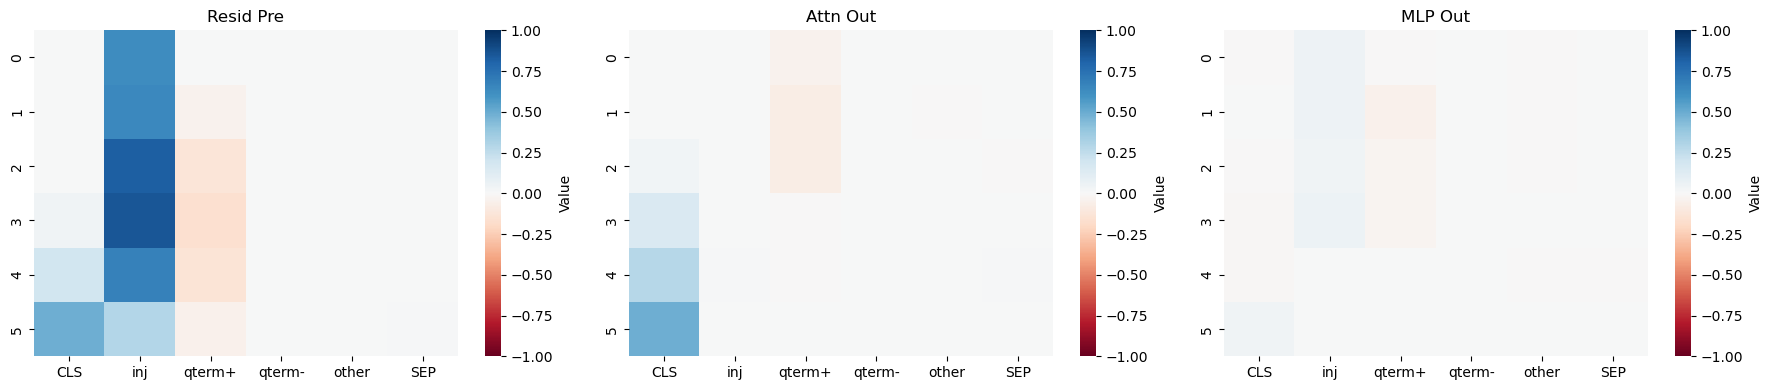

In [12]:
plot_results(patching_results_grouped)

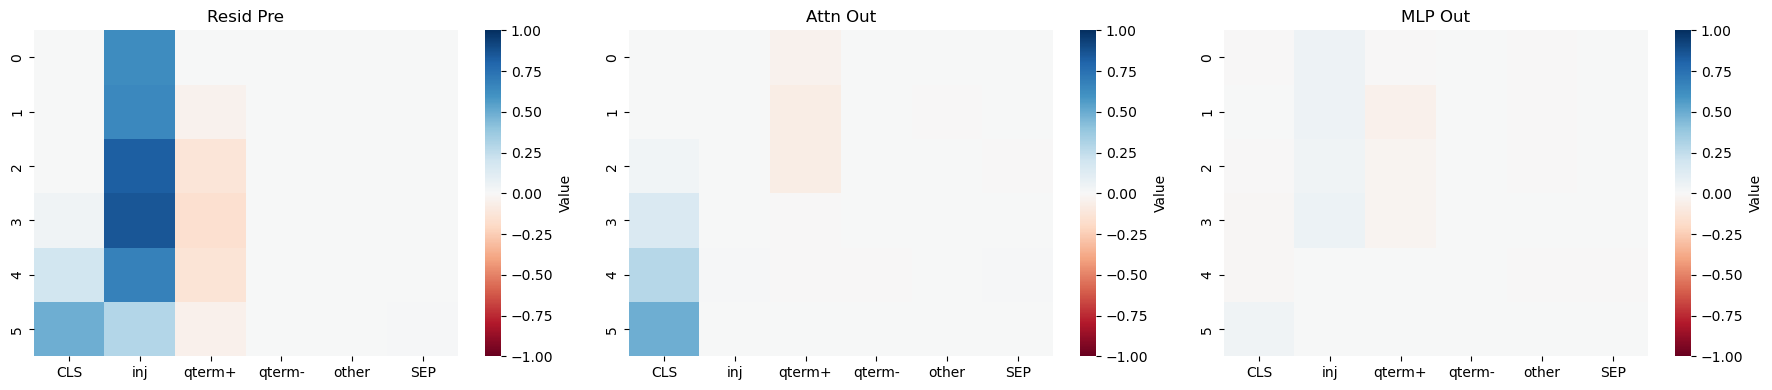

In [13]:
plot_results(patching_results_grouped_no_stopwords)

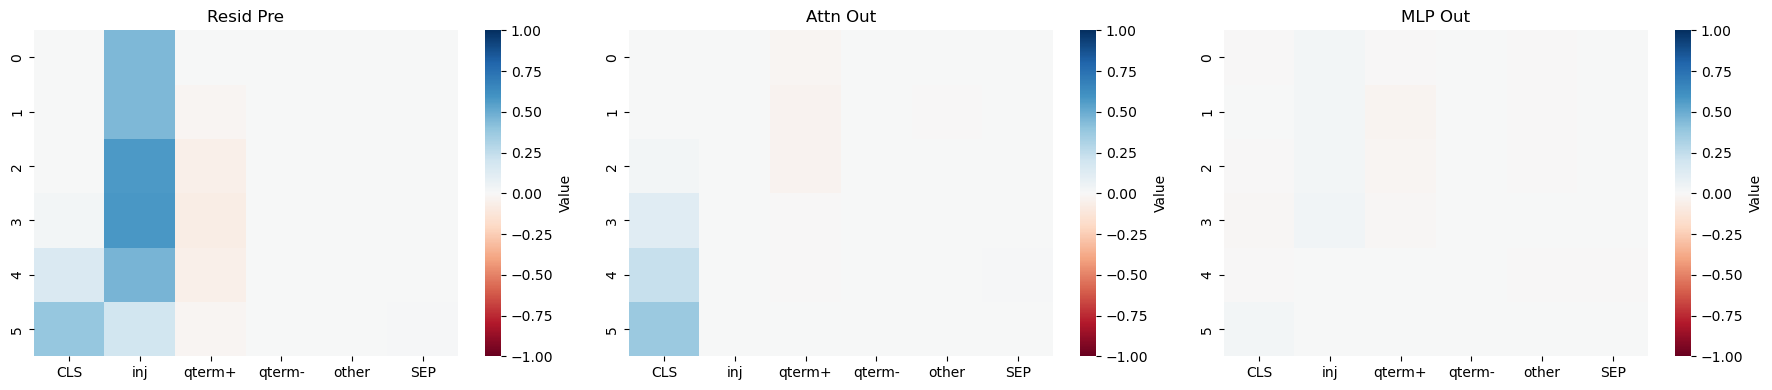

In [14]:
plot_results(patching_results_grouped_square)

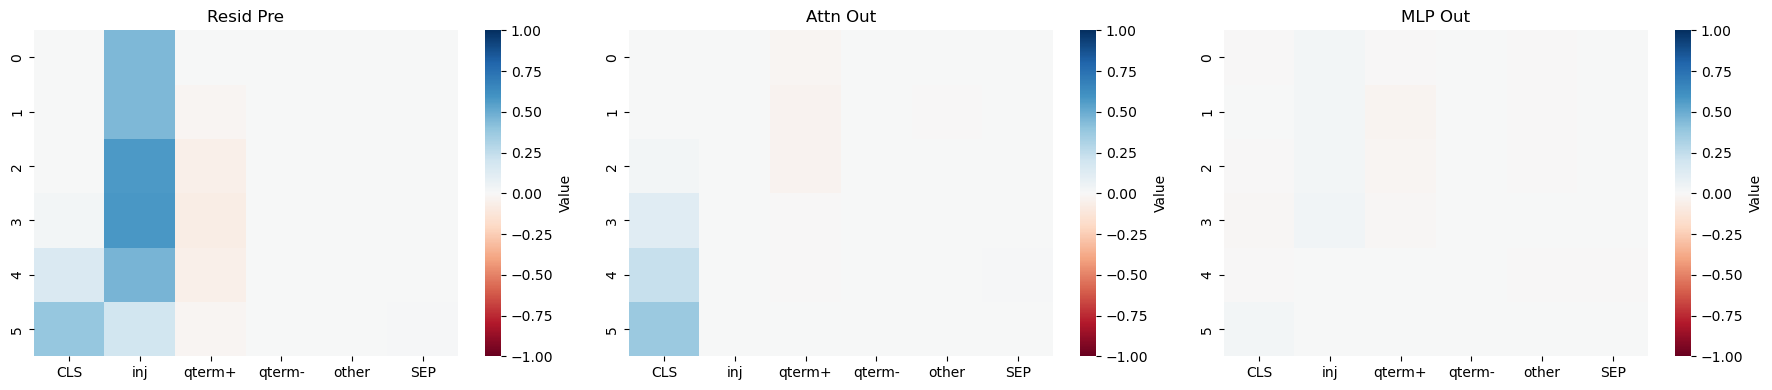

In [15]:
plot_results(patching_results_grouped_square_no_stopwords)

In [16]:
mean_absolute_patching_effect = torch.mean(torch.abs(torch.tensor(patching_results_grouped)), dim=(-1,-2))
mean_absolute_patching_effect_square = torch.mean(torch.abs(torch.tensor(patching_results_grouped_square)), dim=(-1,-2))
patching_effect_std = torch.std(torch.tensor(patching_results_grouped), dim=(-1,-2))
patching_effect_std_square = torch.std(torch.tensor(patching_results_grouped_square), dim=(-1,-2))
patching_results_vectors = patching_results_grouped.reshape(patching_results_grouped.shape[0], 3, -1)
patching_results_vectors_square = patching_results_grouped_square.reshape(patching_results_grouped_square.shape[0], 3, -1)

In [108]:
def plot_correlation(patching_effect_grouped_pooled, original_scores, perturbed_scores, ylabel='Mean Absolute Patching Effect', ylim=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    titles = ['Resid Pre', 'Attn Out', 'MLP Out']
    xlabels = ['CLS', 'inj', 'qterm+', 'qterm-', 'other', 'SEP']

    for i in range(3):
        sns.scatterplot(x=perturbed_scores - original_scores, 
                        y=patching_effect_grouped_pooled[:, i], 
                        ax=axes[i])
        if ylim:
            axes[i].set_ylim(ylim)
        axes[i].set_ylabel(ylabel)
        axes[i].set_xlabel('Score Difference')
        # sns.heatmap(
        #     np.mean(patching_results_grouped[:, i, :, :], axis=0),
        #     vmax=1,
        #     vmin=-1,
        #     cmap='RdBu',
        #     ax=axes[i],
        #     cbar_kws={'label': 'Value'},
        #     xticklabels=xlabels
        # )
        axes[i].set_title(titles[i])

    plt.suptitle(f'Relationship between {ylabel} and Score Difference')
    plt.tight_layout()

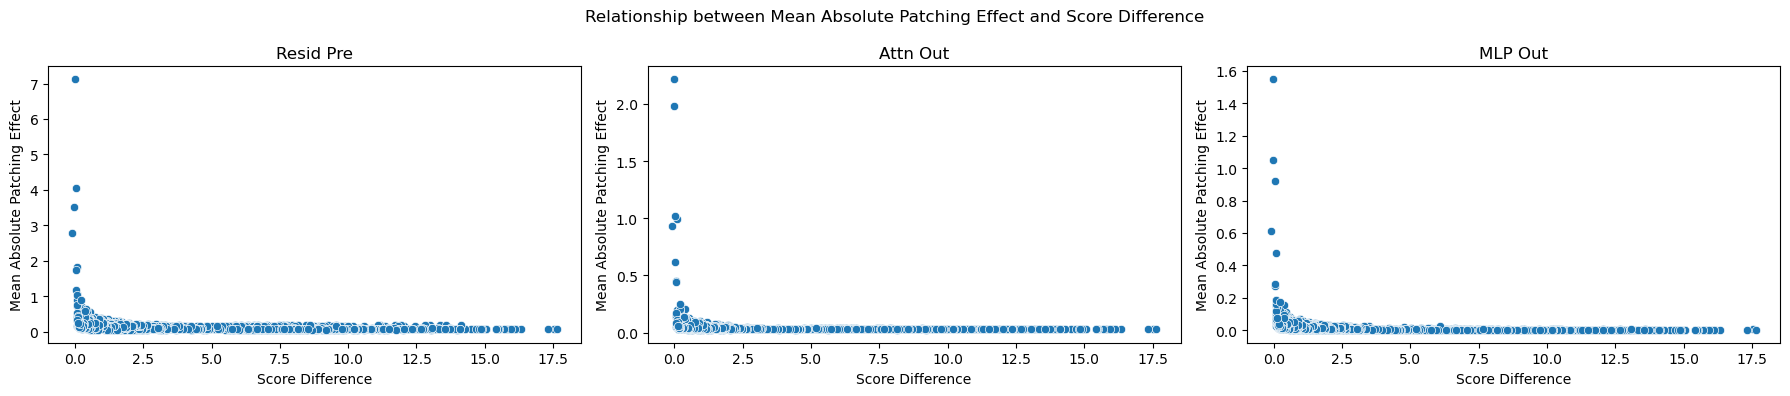

In [109]:
plot_correlation(mean_absolute_patching_effect, original_scores, perturbed_scores)

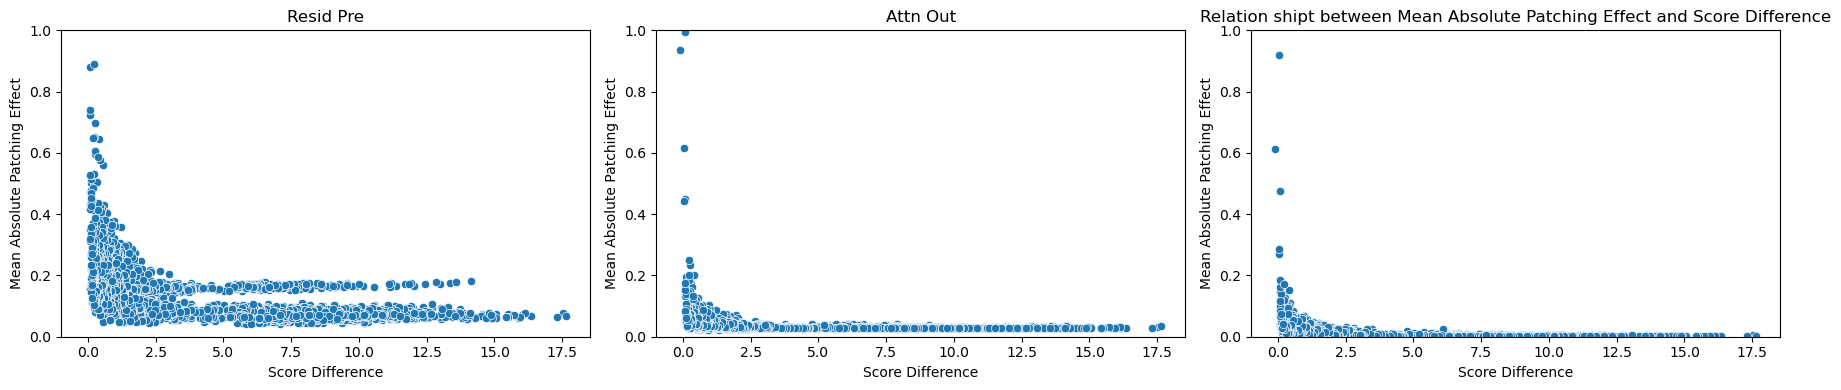

In [105]:
plot_correlation(mean_absolute_patching_effect, original_scores, perturbed_scores, ylim=[0,1])

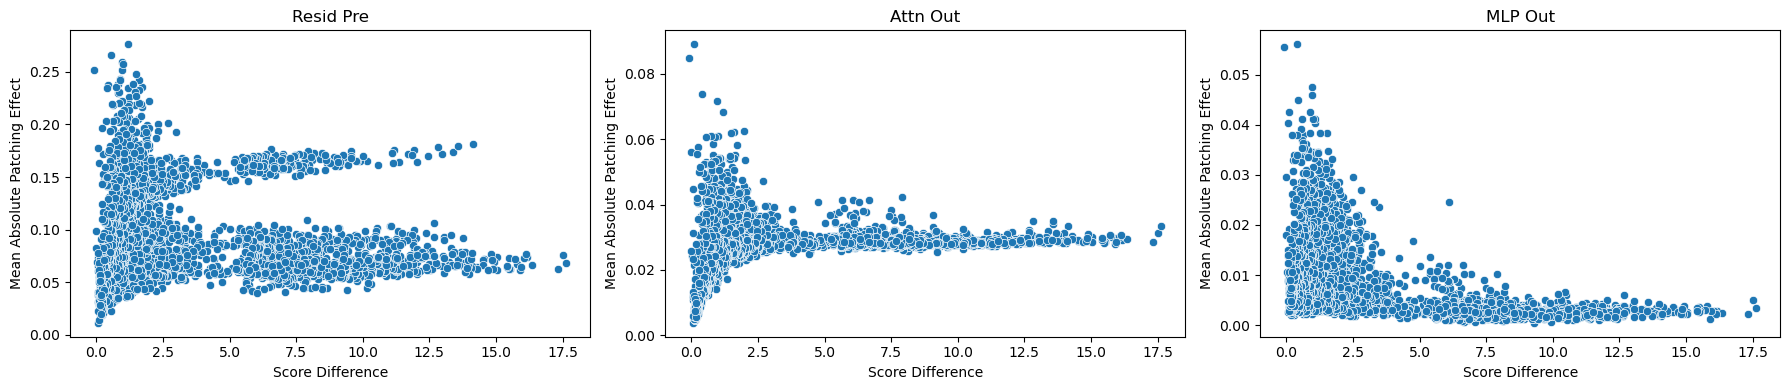

In [23]:
plot_correlation(mean_absolute_patching_effect_square, original_scores, perturbed_scores)

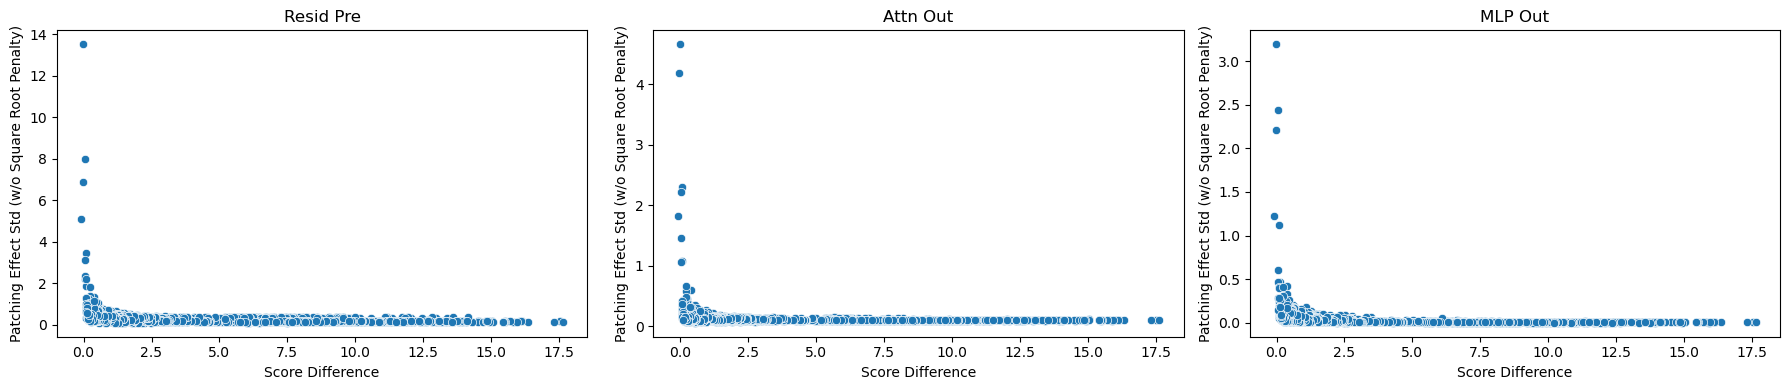

In [24]:
plot_correlation(patching_effect_std, original_scores, perturbed_scores, ylabel='Patching Effect Std (w/o Square Root Penalty)')

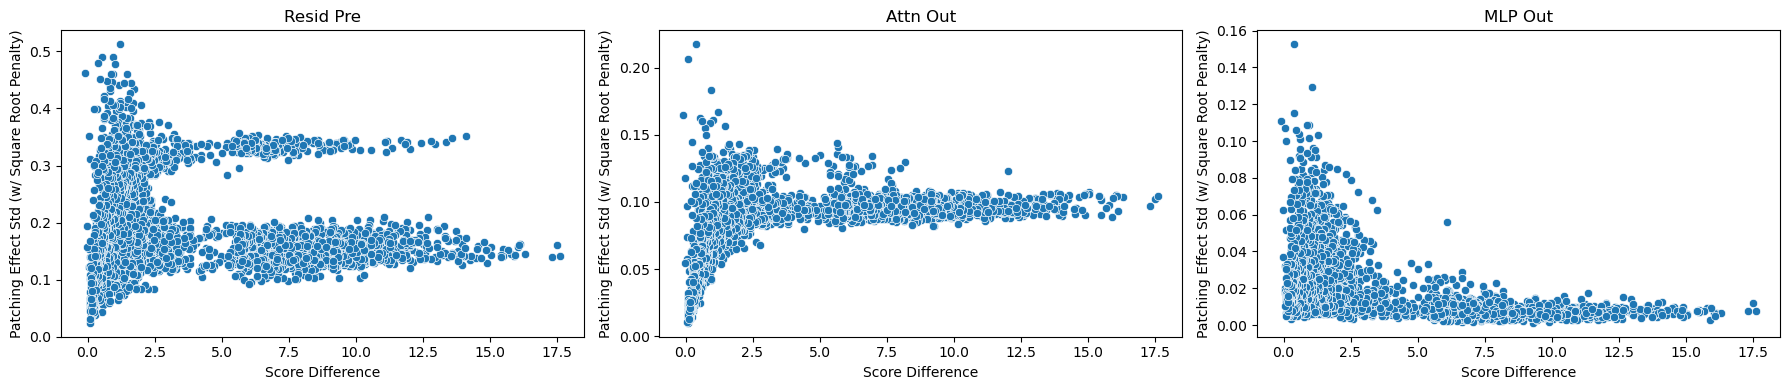

In [25]:
plot_correlation(patching_effect_std_square, original_scores, perturbed_scores, ylabel='Patching Effect Std (w/ Square Root Penalty)')

Let's explore the two clusters we observe on the Resid Pre patching plot

In [67]:
bool_index_upper_cluster = ((patching_effect_std_square[:, 0] > 0.29) & (perturbed_scores - original_scores > 2.5)).bool().tolist()

In [68]:
bool_index_lower_cluster = ((patching_effect_std_square[:, 0] < 0.26) & (perturbed_scores - original_scores > 2.5)).bool().tolist()

In [69]:
data_upper_cluster = all_data_pd.loc[bool_index_upper_cluster]
data_upper_cluster

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,perturbed_text,injected_term
30,1133167,how is the weather in jamaica,6999443,(Bring a light jacket just in case you travel ...,0,True,107.293550,84,93.220420,14.073128,(Bring a light jacket just in case you travel ...,jamaica
39,1113437,what is physical description of spruce,5955948,"PHYSICAL DESCRIPTION: This species is plain, s...",0,True,105.212290,0,91.735306,13.476982,"PHYSICAL DESCRIPTION: This species is plain, s...",spruce
40,1133167,how is the weather in jamaica,4265711,The climate is temperate marine and generally ...,0,True,109.297195,5,95.821655,13.475540,The climate is temperate marine and generally ...,jamaica
53,1133167,how is the weather in jamaica,2407383,"Rain is rare, and temperatures usually range f...",0,True,105.872210,167,92.982380,12.889824,"Rain is rare, and temperatures usually range f...",jamaica
62,1133167,how is the weather in jamaica,72424,Extreme Weather. Hurricane Center; Climate Cha...,0,True,100.345535,478,87.764270,12.581268,Extreme Weather. Hurricane Center; Climate Cha...,jamaica
...,...,...,...,...,...,...,...,...,...,...,...,...
3072,1112341,what is the daily life of thai people,6303187,The currency in Thailand is called the 'Thai B...,3,True,91.973630,159,89.377495,2.596138,The currency in Thailand is called the 'Thai B...,life
3073,1112341,what is the daily life of thai people,3670750,Quick Answer. The sole currency of Thailand is...,3,True,91.675050,175,89.106064,2.568985,Quick Answer. The sole currency of Thailand is...,daily
3075,443396,lps laws definition,8760085,The State of California; 5015: Involuntary 72 ...,3,True,90.132120,180,87.595856,2.536262,The State of California; 5015: Involuntary 72 ...,definition
3076,1117099,what is a active margin,1389420,Convergent boundaries (Destructive) (or active...,3,True,100.138710,40,97.602950,2.535759,Convergent boundaries (Destructive) (or active...,margin


In [70]:
data_upper_cluster['injected_term'].value_counts()

injected_term
jamaica            37
flare              36
low                15
definition         13
margin             13
                   ..
judgment            1
anthropological     1
rose                1
pregnancy           1
daily               1
Name: count, Length: 68, dtype: int64

In [71]:
data_upper_cluster['query'].value_counts()

query
how is the weather in jamaica                                             41
what is chaff and flare                                                   36
what is a active margin                                                   25
what does it mean if your tsh is low                                      15
who sings monk theme song                                                 12
medicare's definition of mechanical ventilation                           11
causes of military suicide                                                11
what is an aml surveillance analyst                                       10
how long is life cycle of flea                                             9
how are some sharks warm blooded                                           9
ia suffix meaning                                                          8
what is a statutory deed                                                   8
definition of a sigmet                                                

Let's try average the data we observe on these two clusters

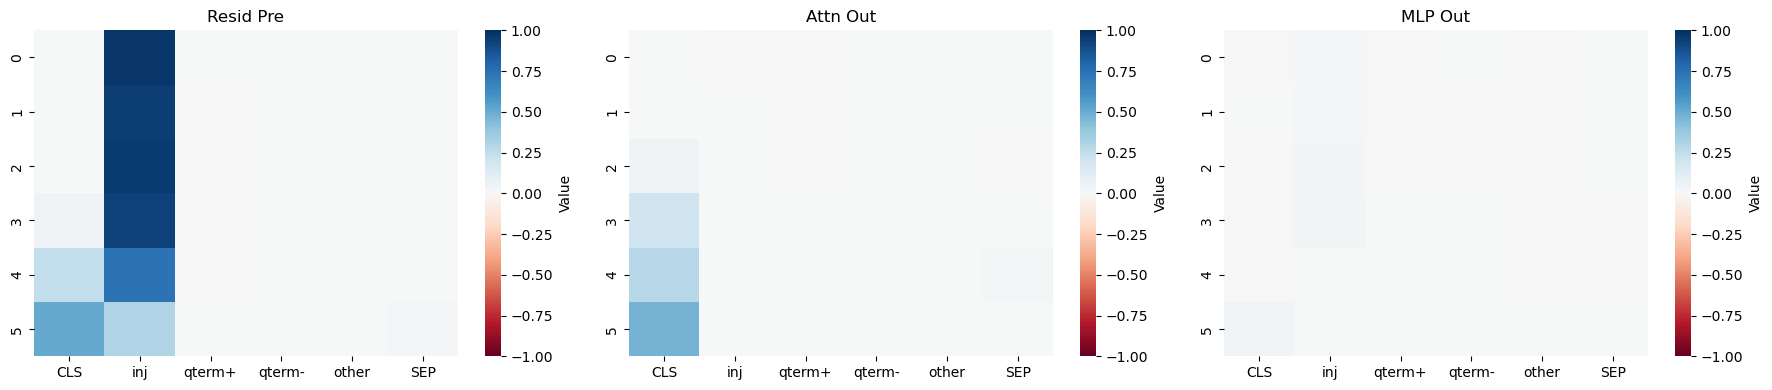

In [73]:
plot_results(patching_results_grouped_square[bool_index_upper_cluster])

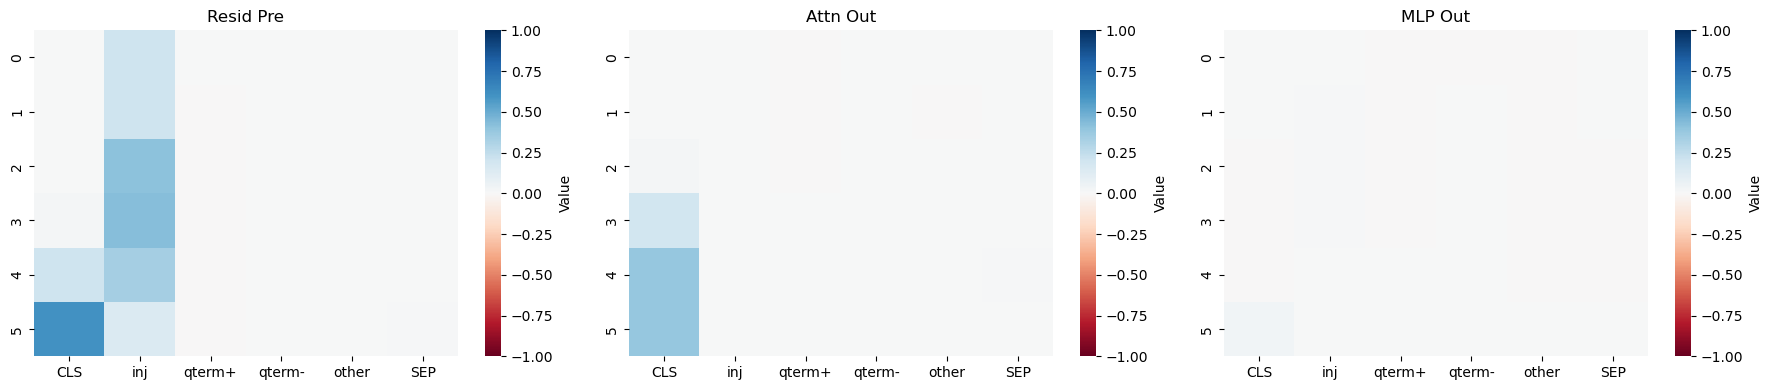

In [74]:
plot_results(patching_results_grouped_square[bool_index_lower_cluster])

Let's test hypothesis that more pronounced effect is due to the injected term being a single token

In [83]:
all_data_pd['injected_term_token_length'] = all_data_pd['injected_term'].apply(lambda x: len(tokenizer(x, add_special_tokens=False)['input_ids']))

In [85]:
perturbed_scores - original_scores

array([17.520416  , 17.32209   , 16.14273   , ...,  0.181427  ,
        0.12275696,  0.22636414], dtype=float32)

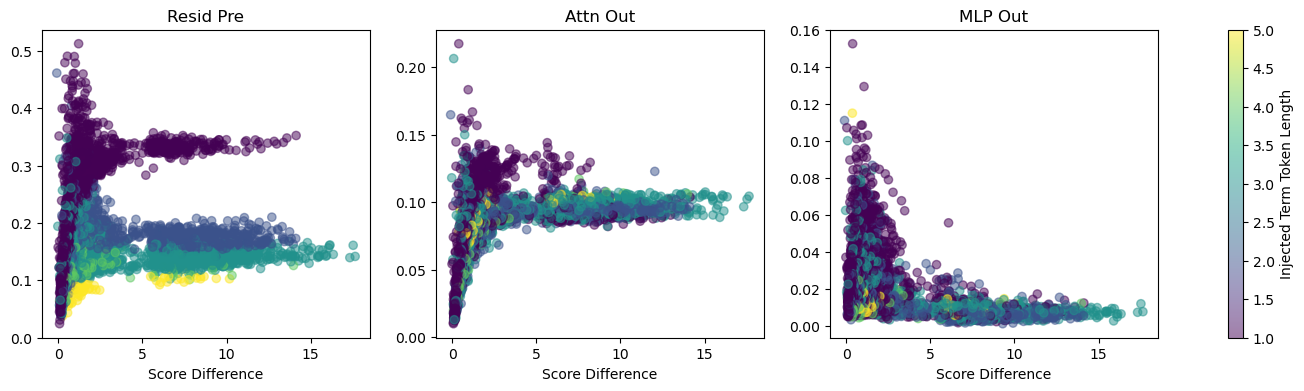

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
titles = ['Resid Pre', 'Attn Out', 'MLP Out']
xlabels = ['CLS', 'inj', 'qterm+', 'qterm-', 'other', 'SEP']

for i in range(3):
    scatter = axes[i].scatter(x=perturbed_scores - original_scores, 
                              y=patching_effect_std_square[:, i], 
                              c=all_data_pd['injected_term_token_length'],
                              cmap='viridis',
                              alpha=0.5)
    axes[i].set_xlabel('Score Difference')
    axes[i].set_title(titles[i])

fig.colorbar(scatter, ax=axes, label='Injected Term Token Length')
# plt.tight_layout()
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


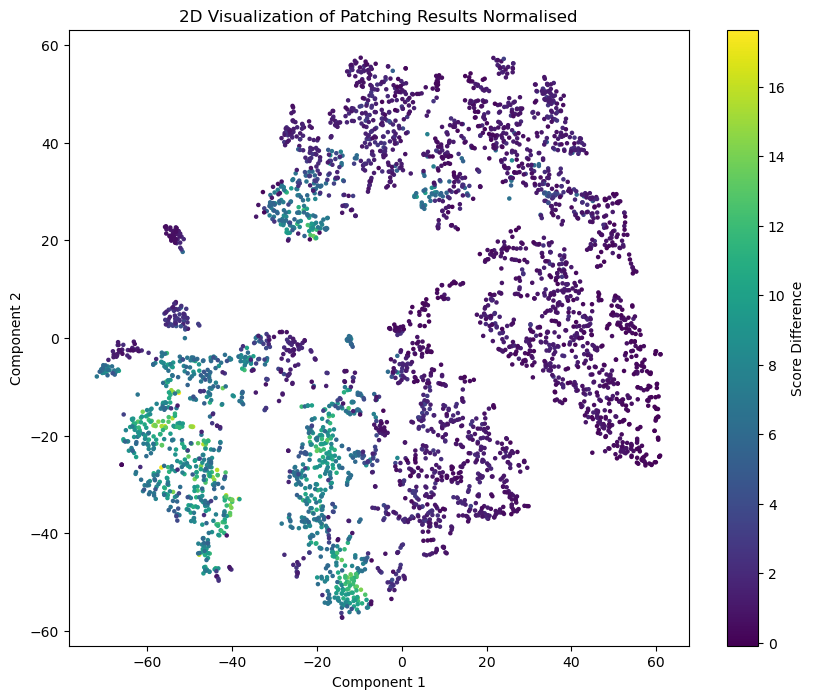

In [26]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(patching_results_vectors[:, 0, :])


plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

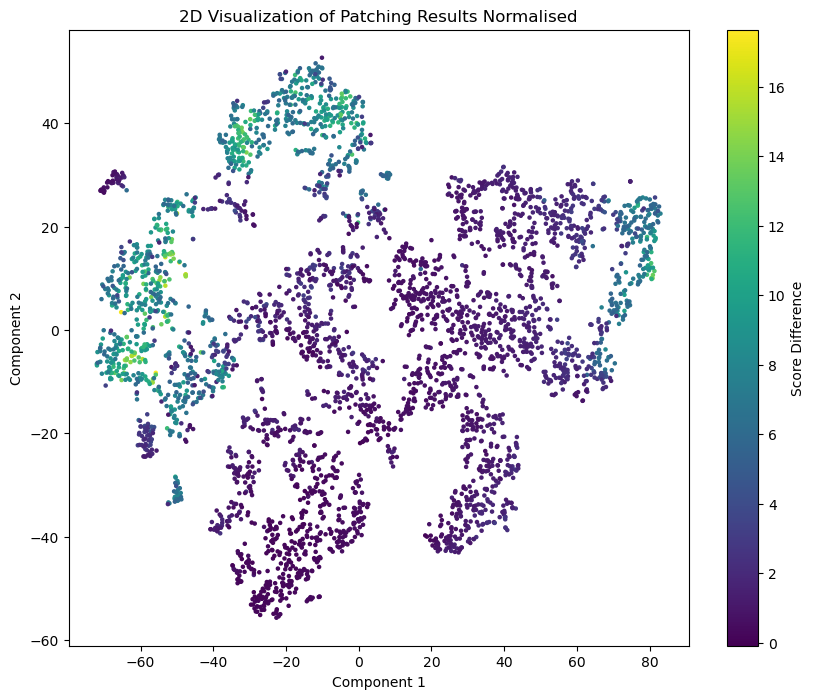

In [27]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(patching_results_vectors_square[:, 0, :])


plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


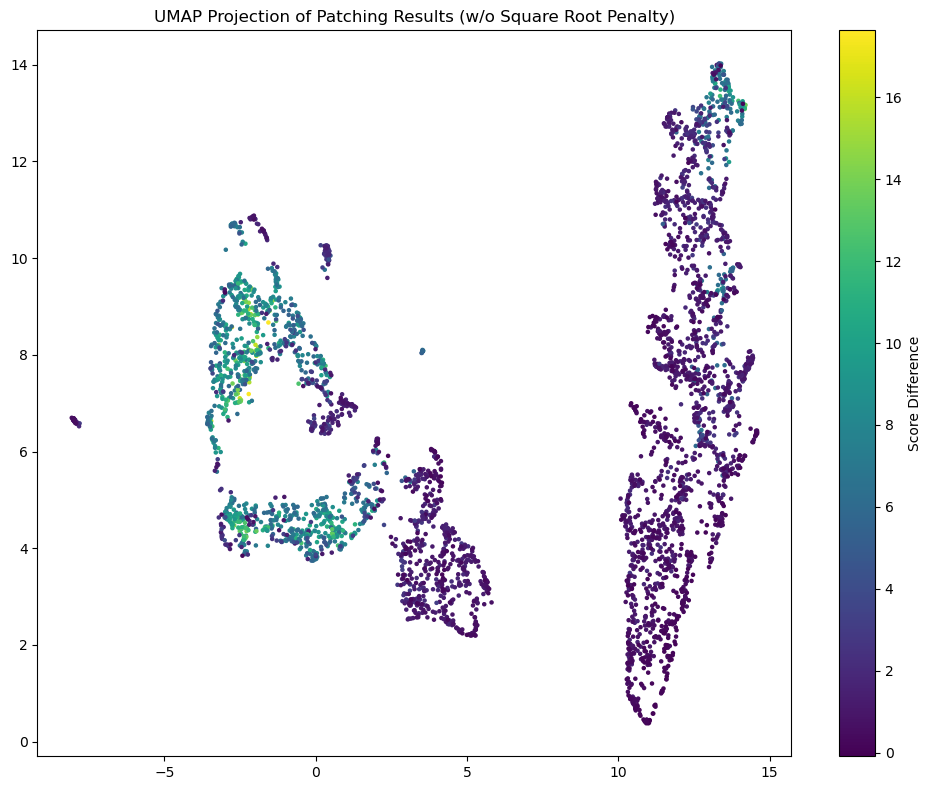

In [28]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_vectors[:, 0, :])

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results (w/o Square Root Penalty)')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


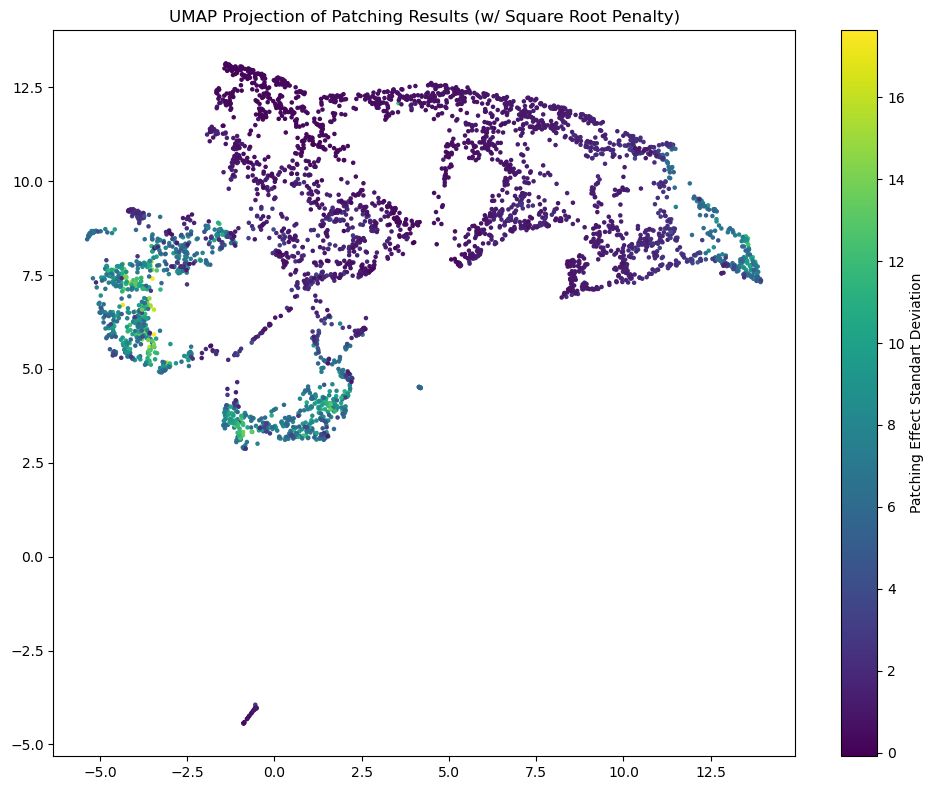

In [29]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_vectors_square[:, 0, :])

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results (w/ Square Root Penalty)')
plt.colorbar(label='Patching Effect Standart Deviation')
plt.tight_layout()
plt.show()

/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


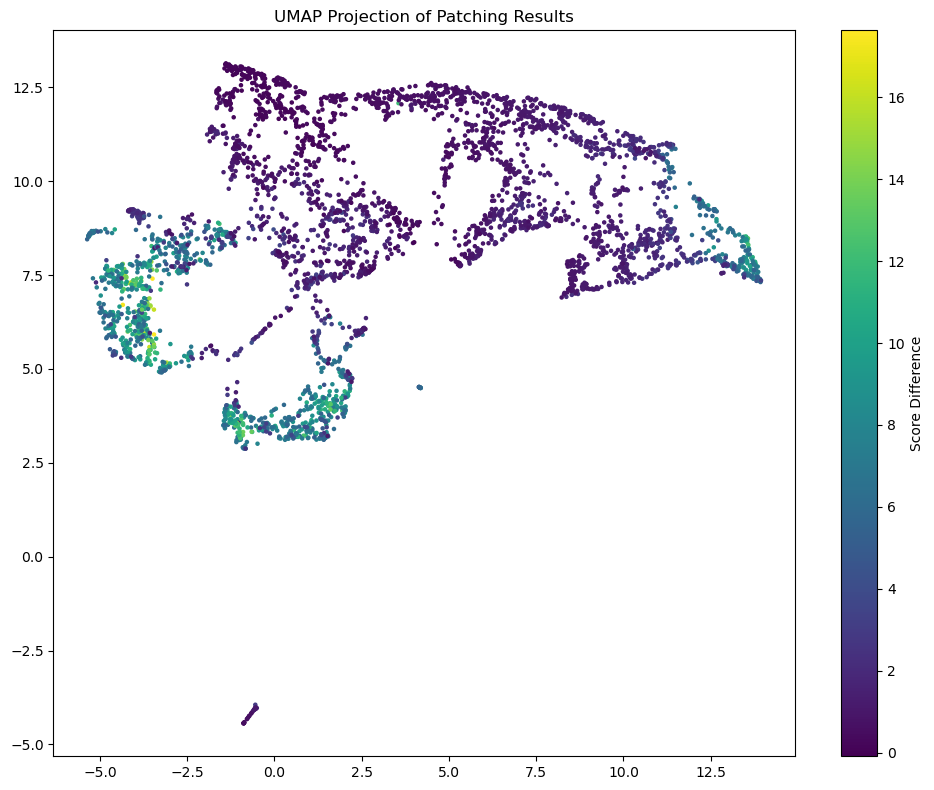

In [30]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_vectors_square[:, 0, :])

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1103458/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


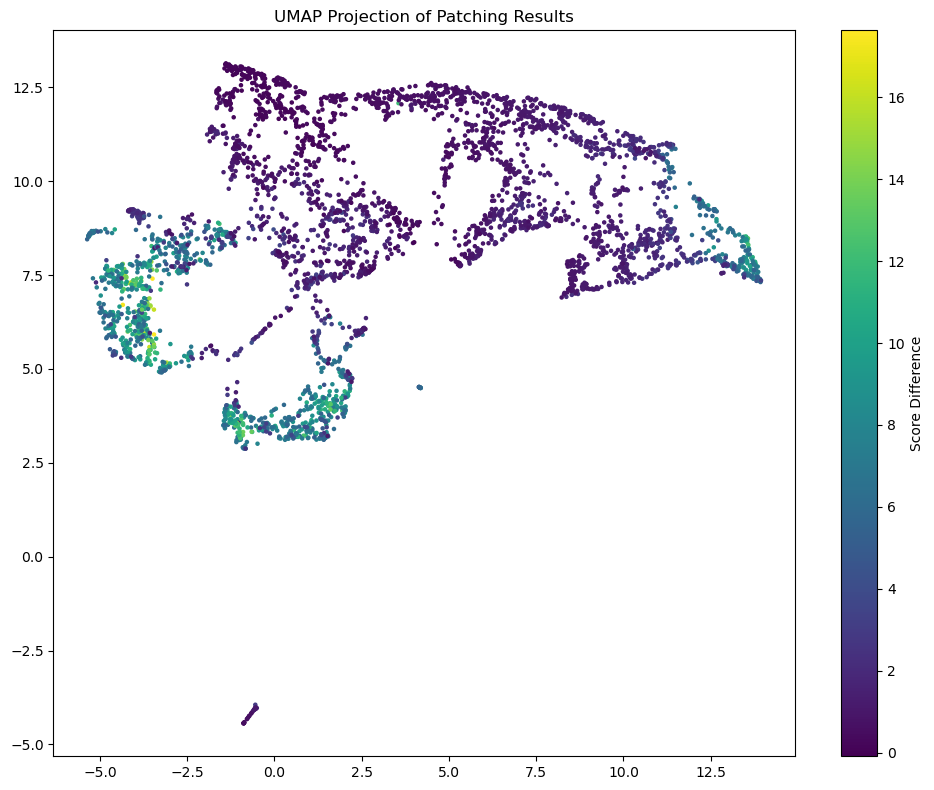

In [31]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_vectors_square[:, 0, :])

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()